## Parameter estimation for a linear operator using Gaussian processes


Assumptions about the linear operator:

$\mathcal{L}_x^\phi u(x) = f(x)$

$u(x) \sim \mathcal{GP}(0, k_{uu}(x,x',\theta))$

$f(x) \sim \mathcal{GP}(0, k_{ff}(x,x',\theta,\phi))$

$y_u = u(X_u) + \epsilon_u; \epsilon_u \sim \mathcal{N}(0, \sigma_u^2I)$

$y_f = f(X_f) + \epsilon_f; \epsilon_f \sim \mathcal{N}(0, \sigma_f^2I)$

Taking a simple operator as example:

$\mathcal{L}_x^\phi := \phi \cdot + \frac{d}{dx}\cdot$

$u(x) = sin(x)$

$f(x) = \phi sin(x) + cos(x)$

Problem at hand:

Given $\{X_u, y_u\}$ and $\{X_f, y_f\}$, estimate $\phi$.


#### step 1: Simulate data


Use $\phi = 2$


In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
x_u = np.linspace(0,2*np.pi,10)
y_u = np.sin(x_u)
x_f = np.linspace(0,2*np.pi, 10)
y_f = 2.0*np.sin(x_f) + np.cos(x_f)

In [3]:
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10,3))
f.suptitle("Input and Output for the operator")
ax1.plot(x_u, y_u)
ax1.set(xlabel= "x", ylabel= "u(x)")
ax2.plot(x_f, y_f, 'r')
ax2.set(xlabel= "x", ylabel= "f(x)")

[<matplotlib.text.Text at 0x1154112e8>, <matplotlib.text.Text at 0x1153fbbe0>]

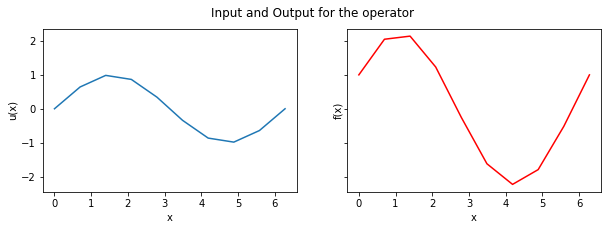

In [4]:
plt.show()

#### step 2: Evaluate kernels



This step uses information about $\mathcal{L}_x^\phi$ but not about $u(x)$ or $f(x)$.

$k_{uu}(x_i, x_j; \theta) = \theta exp(-\frac{1}{2}(x_i-x_j)^2)$


In [5]:
x_i, x_j, theta, phi = sp.symbols('x_i x_j theta phi')
kuu_sym = theta*sp.exp(-1/(2)*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta), kuu_sym, "numpy")
def kuu(x, theta):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta)
    return k

$k_{ff}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\phi \mathcal{L}_{x_j}^\phi k_{uu}(x_i, x_j; \theta) \\
= \mathcal{L}_{x_i}^\phi \left( \phi k_{uu} + \frac{\partial}{\partial x_j}k_{uu} \right) \\
= \phi^2 k_{uu} + \phi \frac{\partial}{\partial x_j}k_{uu} + \phi \frac{\partial}{\partial x_i}k_{uu} + \frac{\partial}{\partial x_i}\frac{\partial}{\partial x_j}k_{uu}$

More explicit calculations follow:

$\mathcal{L}_{x_i}^\phi \mathcal{L}_{x_j}^\phi \left[ \theta exp(-\frac{1}{2}(x_i-x_j)^2) \right] \\
= \mathcal{L}_{x_i}^\phi \left[ \theta exp(-\frac{1}{2}(x_i-x_j)^2)\left(\phi + (-\frac{1}{2})2(x_i-x_j)(-1) \right) \right] \\
= \mathcal{L}_{x_i}^\phi \left[\theta exp(-\frac{1}{2}(x_i-x_j)^2)(\phi + x_i - x_j) \right] \\
= \phi \theta exp(-\frac{1}{2}(x_i-x_j)^2)(\phi+x_i-x_j) + \theta exp(-\frac{1}{2}(x_i-x_j)^2)\left[ -\frac{1}{2}2(x_i-x_j)(\phi+x_i-x_j) + 1 \right] \\
= \theta exp(-\frac{1}{2}(x_i-x_j)^2)\left[ \phi^2 - (x_i-x_j)^2 + 1 \right]$

In [6]:
kff_sym = phi**2*kuu_sym \
            + phi*sp.diff(kuu_sym, x_j) \
            + phi*sp.diff(kuu_sym, x_i) \
            + sp.diff(kuu_sym, x_j, x_i)
kff_fn = sp.lambdify((x_i, x_j, theta, phi), kff_sym, "numpy")
def kff(x, theta, phi):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, phi)
    return k

$k_{fu}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\phi k_{uu}(x_i, x_j; \theta) \\
= \phi k_{uu} + \frac{\partial}{\partial x_i}k_{uu}  \\
= \mathcal{L}_{x_i}^\phi \left[ \theta exp(-\frac{1}{2}(x_i-x_j)^2) \right] \\
= \theta exp(-\frac{1}{2}(x_i-x_j)^2) \left[ (-\frac{1}{2})2(x_i-x_j) + \phi \right] \\
= \theta exp(-\frac{1}{2}(x_i-x_j)^2)(\phi-x_i+x_j)$

In [7]:
kfu_sym = phi*kuu_sym + sp.diff(kuu_sym, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, phi), kfu_sym, "numpy")
def kfu(x1, x2, theta, phi):
    k = np.zeros((x1.size, x2.size))
    for i in range(x1.size):
        for j in range(x2.size):
            k[i,j] = kfu_fn(x1[i], x2[j], theta, phi)
    return k

$k_{uf}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_j}^\phi k_{uu}(x_i, x_j; \theta) \\
= \mathcal{L}_{x_j}^\phi \left[ \theta exp(-\frac{1}{2}(x_i-x_j)^2) \right] \\
= \theta exp(-\frac{1}{2}(x_i-x_j)^2) \left[ (-\frac{1}{2})2(x_i-x_j)(-1) + \phi \right]\\
= \theta exp(-\frac{1}{2}(x_i-x_j)^2)(\phi+x_i-x_j)$

In [8]:
def kuf(x1, x2, theta, phi):
    return kfu(x1,x2,theta,phi).T

#### step 3: define negative log marginal likelihood  



$K = \begin{bmatrix}
k_{uu}(X_u, X_u; \theta) + \sigma_u^2I & k_{uf}(X_u, X_f; \theta, \phi) \\
k_{fu}(X_f, X_u; \theta, \phi) & k_{ff}(X_f, X_f; \theta, \phi) + \sigma_f^2I
\end{bmatrix}$

For simplicity, assume $\sigma_u = \sigma_f$.

$\mathcal{NLML} = \frac{1}{2} \left[ log|K| + y^TK^{-1}y + Nlog(2\pi) \right]$

where $y = \begin{bmatrix}
y_u \\
y_f
\end{bmatrix}$

In [9]:
def nlml(params, x1, x2, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [
            kuu(x1, params[0]) + s*np.identity(x1.size),
            kuf(x1, x2, params[0], params[1])
        ],
        [
            kfu(x1, x2, params[0], params[1]),
            kff(x2, params[0], params[1]) + s*np.identity(x2.size)
        ]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) \
               + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [10]:
nlml((1, 0.69), x_u, x_f, y_u, y_f, 1e-6)

-29.31407097906228

#### step 4: Optimise hyperparameters


In [11]:
nlml_wp = lambda params: nlml(params, x_u, x_f, y_u, y_f, 1e-6)
m = minimize(nlml_wp, np.random.rand(2), method="Nelder-Mead")

In [12]:
m

 final_simplex: (array([[-1.45264123,  0.69314826],
       [-1.45256954,  0.69314826],
       [-1.45259815,  0.6931485 ]]), array([-54.80042074, -54.80042073, -54.80042071]))
           fun: -54.80042073904191
       message: 'Optimization terminated successfully.'
          nfev: 125
           nit: 66
        status: 0
       success: True
             x: array([-1.45264123,  0.69314826])

In [13]:
np.exp(m.x)

array([0.23395155, 2.00000216])

### Using pyGPs (Arthur's Idea)

In [14]:
import pyGPs
model_u = pyGPs.GPR()
model_u.setData(x_u, y_u)
model_u.optimize(x_u, y_u)

model_f = pyGPs.GPR()
model_f.setData(x_f, y_f)
model_f.optimize(x_f, y_f)


Number of line searches 14
Number of line searches 40


In [15]:
print(np.exp(model_f.covfunc.hyp))
print(np.exp(model_u.covfunc.hyp))

[2.95505782 5.66783684]
[3.05575196 3.43396255]


In [16]:
s_u = np.exp(model_u.covfunc.hyp[1])
l_u = np.exp(model_u.covfunc.hyp[0])
s_f = np.exp(model_f.covfunc.hyp[1])
phi = ((s_f/s_u)**2 - 1/l_u**2)**0.5
phi

1.6177561845589767

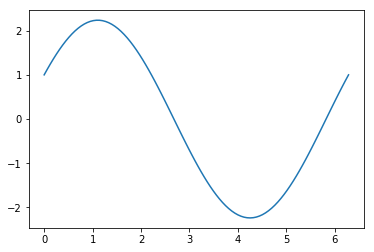

In [17]:
x_p = np.linspace(0,2*np.pi,100)
y_p = model_f.predict(x_p)
# plot predictions
plt.plot(x_p,y_p[0])
plt.show()